# Redes Convolucionales Pre-entrenadas

In [1]:
import keras
keras.__version__

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

Una aproximación muy común y efectiva cuando se trabaja con Deep Learning sobre datasets pequeños es reutilizar redes preentrenadas. Una red preentrenada es simplemente una red grabada que ha sido entrenada sobre un dataset grande, algo muy común cuando se trabaja con problemas de clasificación de imágenes. 

Si este dataset original es suficientemente grande y suficientemente general, entonces la jerarquía de características espaciales que ha aprenido la red preentrenada puede servir como modelo genérico de nuestro mundo visual y, por tanto, sus características pueden ser útiles para muchos problemas de visión diferentes, incluso aunque estos nuevos problemas involucren clases completamente distintas a las de la tarea original. 

Por ejemplo, uno puede entrenar una red sobre [ImageNet](http://www.image-net.org) (donde las clases son principalmente de animales y objetos de uso diario) y reutilizarlo para algo tan distinto como identificar muebles. Esta portabilidad de características aprendidas entre diferentes problemas (que se suele denominar **Transfer Learning**, o **Transferencia de Aprendizaje**) es una ventaja clave de Deep Learning en comparación con muchas otras aproximaciones clásicas de ML, y hace que DL pueda ser apropiado para atacar problemas con datasets pequeños (en contra de lo que se cree generalmente).

En el ejemplo que vamos a ver a continuación consideraremos una CNN entrenada sobre el dataset ImageNet (usando 1.4 millones de imágenes etiquetadas en 1,000 clases diferentes), que contiene clases de muchos animales, en particular diferentes razas de gatos y perros, así que podemos esperar que funcione bien sobre el problema de clasificación que vimos en el ejemplo anterior (Cats and Dogs).

Vamos a usar la arquitectura [VGG16](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), desarrollada por Karen Simonyan y Andrew Zisserman en 2014, y que ha sido muy usada desde entonces para este tipo de problemas. Aunque es un modelo un poco viejo, y ya superado por muchos otros modelos similares, lo usaremos porque hace uso de arquitecturas parecidas a las de ejemplos anteriores, permitiéndonos concentrarnos en las novedades que introduciremos.

![](vgg16.png)

En los que sigue, vamos a hacer dos aproximaciones para reutilizar modelos pre-entrenados: **Extracción de Características** y **Ajuste Fino**.

## Extracción de Características

La **Extracción de Características** consiste en usar representaciones aprendidas por otras redes para extraer características interesantes de nuevas muestras. Tras esta extracción, se usa la nueva representación dada por estas características para alimentar un nuevo clasificador, que (esta vez sí) será entrenado desde cero.

Como hemos visto en los ejemplos anteriores, las CNN usadas para clasificación de imágenes constan de dos partes bien diferenciadas: comienza por una serie de capas alternadas de convolución y pooling (lo que se llama la **base convolucional**), y acaban con un clasificador de capas densas. Nosotros aprovecharemos la base convolucional de la red preentrenada para obtener las nuevas representaciones y entrenaremos un nuevo codificador en la última parte.

Es importante entender porqué reusamos únicamente la base convolucional y no usamos también la parte del clasificador denso. La razón de ignorar esta última parte es simplemente que las representaciones aprendidas en la base convolucional son más genéricas y reutilizables, contienen información acerca de conceptos genéricos, que parecen útiles para todo tipo de problemas de visión artificial. Por otra parte, las representaciones aprendidas por el clasificador son mucho más específicas y relacionadas con el problema concreto para el que se ha entrenado y las clases de ese problema. Además estas capas densas pierden información acerca de dónde se sitúan las características aprendidas, algo que puede ser útil en algunos casos.

El nivel de generalidad (y por tanto de reusabilidad) de las representaciones extraídas por las capas convolucionales dependen de la profundidad de las capas del modelo. Las primeras capas extraen mapas de características muy genéricas y locales (bordes, colores, texturas, etc.), mientras que las capas más profundas extraen conceptos abstractos más elevados (como "orejas", "ojos", etc.). En consecuencia, si el dataset sobre el que se trabaja difiere mucho del dataset original con el que fue entrenada la red, es mejor usar solo las primeras capas, y no la base convolucional completa.

En nuestro caso, intentando clasificar gatos y perros, podríamos llegar a usar incluso las redes densas de la red preentrenada, porque esas clases están contenidas en el problema original, pero nos quedaremos solo con la base convolucional para que el ejemplo sea lo más generalizable posible.

Además del modelo VGG16, Keras trae otros modelos preentrenados aptos para clasificación de imágenes, como [Xception](https://arxiv.org/pdf/1610.02357.pdf), [InceptionV3](https://arxiv.org/abs/1512.00567), [ResNet50](https://arxiv.org/abs/1512.03385), [VGG16](https://arxiv.org/abs/1409.1556), [VGG19](https://arxiv.org/abs/1409.1556), [MobileNet](https://arxiv.org/pdf/1704.04861.pdf), [DenseNet](https://arxiv.org/abs/1707.07012), ...

Recuerda que la primera vez que ejecutes el siguiente código se descargará el modelo preentrenado:

In [3]:
from keras.applications import VGG16
from keras.utils.vis_utils import plot_model

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

plot_model(conv_base, to_file='conv_base_plot.png', show_shapes=True, show_layer_names=True)

Hemos pasado 3 argumentos al constructor:

* `weights`, especifica el juego de pesos para inicializar el modelo (en nuestro caso, los asociados al problema ImageNet).
* `include_top`, indica si se debe incluir, o no, las capas densas de la red (las que se ajustan a la clasificación de las 1,000 clases de ImageNet).
* `input_shape`, la forma de los tensores de entrada. Es opcional, y si no se indicara se podrían pasar entradas de cualquier tamaño, pero en nuestro caso lo tenemos perfectamente prefijado para que el procedimiento sea similar al que hicimos en el ejemplo anterior.

Podemos comprobar que la base convolucional de VGG16 es muy parecida a la arquitectura generada para problemas anteriores:

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

El mapa de características final tiene la forma `(4, 4, 512)`. Aquí conectaremos nuestro clasificador de capas densas.

En este punto, hay dos posibles vías para proceder: 

* Ejecutar la base convolucional sobre el dataset, grabar su salida en un array, y entonces usar estos datos como entrada de un clasificador denso independiente parecido al que vimos anteriormente. Esta solución es rápida y fácil de ejecutar, porque solo requiere ejecutar la base convolucional una vez sobre cada imagen de entrada, que es la parte que más recursos consume del proceso. Por contrario, esta opción no permite hacer uso de *data augmentation*.
* Extender el modelo (`conv_base`) añadiendo capas densas encima, y ejecutar la red completa sobre los datos de entrada. Esta opción permite hacer uso de *data augmentation*, aunque consume muchos más recursos que la primera opción.

Con el fin de poder compararlas, vamos a mostrar ambas técnicas.

Comenzaremos por la primera opción: ejecutar `conv_base` sobre todos los datos para después usar los resultados como datos de entrada en un modelo nuevo. Comenzaremos ejecutando `image_data_generator()` de forma similar a como hicimos en el caso anterior para extraer las imágenes como arrays (y sus etiquetas). Posteriormente, ejecutaremos el método `predict` del modelo sobre estos arrays para extraer las características asociadas.

In [5]:
import os
os.getcwd()

'/home/dasolma/DL/4. Redes Convolucionales'

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../../data/cat_dogs'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Las características extraidas tienen la forma `(samples, 4, 4, 512)`. A continuación alimentaremos un clasificador denso, pero hemos de aplanar los tensores para pasar  `(samples, 4 * 4 * 512)`:


In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Ya podemos definir nuestro clasificador denso (introducimos una capa de dropout para regularización), y entrenamos con los datos que acabamos de generar con la base convolucional:


In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 295us/step - loss: 0.6119 - acc: 0.6575 - val_loss: 0.4540 - val_acc: 0.8110
Epoch 2/30
2000/2000 [==============================] - 0s 166us/step - loss: 0.4326 - acc: 0.8040 - val_loss: 0.3527 - val_acc: 0.8620
Epoch 3/30
2000/2000 [==============================] - 0s 166us/step - loss: 0.3566 - acc: 0.8395 - val_loss: 0.3172 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 0s 162us/step - loss: 0.3048 - acc: 0.8810 - val_loss: 0.3011 - val_acc: 0.8750
Epoch 5/30
2000/2000 [==============================] - 0s 162us/step - loss: 0.2846 - acc: 0.8825 - val_loss: 0.2821 - val_acc: 0.8850
Epoch 6/30
2000/2000 [==============================] - 0s 162us/step - loss: 0.2586 - acc: 0.9055 - val_loss: 0.2667 - val_acc: 0.8890
Epoch 7/30
2000/2000 [==============================] - 0s 161us/step - loss: 0.2454 - acc: 0.8960 - val_loss: 0.2610 - val_acc: 0.8920


El entrenamiento es muy rápido, ya que solo tiene dos capas densas. Veamos los resultados que se obtienen:


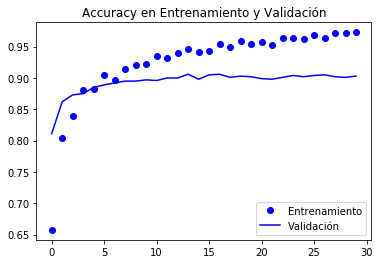

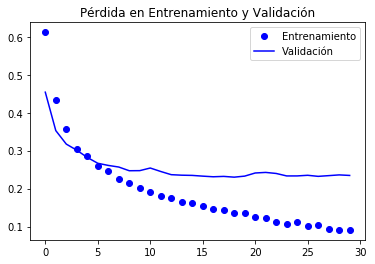

In [10]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history.history['acc']
val_acc = history.history['val_acc']
ent_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()


Hemos alcanzado una precisión de ~90%, mucho más elevada que lo que conseguimos con la red convolucional entrenada completamente por nosotros en el ejemplo anterior. Sin embargo, la gráfica muestra que se sigue produciendo un sobreajuste casi desde el principio (incluso habiendo puesto una capa de dropout). Este problema se debe que el modelo hace uso de un dataset muy pequeño, que no ha sido mejorado por medio de data augmentation.

Por ello, pasamos a aplicar la segunda técnica, que es mucho más lenta y cara (quizás no sea conveniente que lo intentes si no tienes una GPU a mano, en ese caso, es preferible que hagas uso de la técnica anterior), pero que permitirá evitar el problema del sobreajuste: extendemos el modelo `conv_base` con nuestras propias capas densas y ejecutamos por completo el entrenamiento de la primera capa hasta la última. 

Como los modelos se comportan igual que las capas, podemos añadir el modelo `conv_base` a un modelo secuencial como si fuera una capa más:

In [14]:
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

El modelo resultante es:
![](model2_plot.png)

In [15]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Como puedes observar, la base convolucional de VGG16 tiene 14,714,688 parámetros, y sobre ella hemos añadido un clasificador con otros 2 millones de parámetros.

Antes de compilar y entrenar tu modelo, recuerda q es importante **congelar** la base convolucional, lo que significa que durante el proceso de entrenamiento los pesos de sus capas **no** serán modificados. Si no se hace así, las representaciones aprendidas en el entrenamiento original se modificarían. Como las capas densas que se añaden se inicializan aleatoriamente, habría grandes modificaciones sobre los pesos que se propagarían a través de la red, lo que destruiría el aprendizaje previo.

Keras proporciona la propiedad `trainable` a las capas para indicar si deben estar congeladas o no:

In [16]:
print('Nº de pesos entrenables antes de congelar la base convolucional:', len(model2.trainable_weights))

Nº de pesos entrenables antes de congelar la base convolucional: 30


In [17]:
conv_base.trainable = False

model2.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [18]:
print('Nº de pesos entrenables tras congelar la base convolucional:', len(model.trainable_weights))

Nº de pesos entrenables tras congelar la base convolucional: 4


Indica 4 pesos por entrenar porque son 2 capas, y en cada capa se considera la matriz de pesos y la de bias. Es importante tener en cuenta que tras congelar las capas debes compilar el modelo, si no, no tendrá efecto.

Ya podemos entrenar el modelo haciendo uso de la misma técnica de data augmentation que vimos antes:

In [19]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

entrenamiento = model2.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 12s - loss: 0.5914 - acc: 0.6990 - val_loss: 0.4549 - val_acc: 0.8300
Epoch 2/30
 - 11s - loss: 0.4819 - acc: 0.7840 - val_loss: 0.3699 - val_acc: 0.8690
Epoch 3/30
 - 11s - loss: 0.4380 - acc: 0.8125 - val_loss: 0.3281 - val_acc: 0.8790
Epoch 4/30
 - 11s - loss: 0.4044 - acc: 0.8190 - val_loss: 0.3077 - val_acc: 0.8790
Epoch 5/30
 - 11s - loss: 0.3782 - acc: 0.8350 - val_loss: 0.2987 - val_acc: 0.8830
Epoch 6/30
 - 11s - loss: 0.3776 - acc: 0.8355 - val_loss: 0.2957 - val_acc: 0.8810
Epoch 7/30
 - 11s - loss: 0.3639 - acc: 0.8430 - val_loss: 0.2765 - val_acc: 0.8930
Epoch 8/30
 - 11s - loss: 0.3596 - acc: 0.8380 - val_loss: 0.2705 - val_acc: 0.8910
Epoch 9/30
 - 11s - loss: 0.3507 - acc: 0.8460 - val_loss: 0.2637 - val_acc: 0.8950
Epoch 10/30
 - 11s - loss: 0.3340 - acc: 0.8495 - val_loss: 0.2563 - val_acc: 0.8970
Epoch 11/30
 - 11s - loss: 0.3391 - acc: 0.8395 - val_loss: 0.2552 - val_ac

Y grabamos el modelo resultante:


In [14]:
model.save('cats_and_dogs_3.h5')

Si vemos los resultados obtenidos:


In [30]:
ent_acc = entrenamiento.history['acc']
val_acc = entrenamiento.history['val_acc']
ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

NameError: name 'entrenamiento' is not defined

Vemos que alcanzamos también una precisión del 90%.


## Ajuste Fino (Fine Tuning)

Otra técnica muy usada para la reutilización de modelos, complementaria a la de extracción de características, consiste en lo que se conoce como **Ajuste Fino**, que consiste en descongelar algunas de las capas superiores de la base convolucional (usada para la extracción de características) y entrenarlas conjuntamente con las capas de clasificación que se han añadido sobre ellas. Se llama así porque ajusta ligeramente las representaciones más abstractas del modelo que se reusa con el fin de que se adapten al problema concreto que estamos intentando resolver.

Antes dijimos que era necesario congelar la base convolucional de VGG16 con el fin de poder entrenar el clasificador (inicializado aleatoriamente) que se ha situado encima. Por las mismas razones, solo es posible hacer un ajuste fino de las capas superiores si el clasificador que se pone encima ya ha sido entrenado de alguna forma porque, en caso contrario, el error se propagará hacia el interior de la red y perderá de nuevo las representaciones aprendidas por esas capas. Por tanto, los pasos a seguir para un ajuste fino serán:

1. Añadir la red personalizada sobre la base de la red preentrenada.
2. Congelar la base preentrenada.
3. Entrenar la parte que has añadido.
4. Descongelar algunas capas superiores de la base preentrenada.
5. Entrenar conjuntamente todas las capas (las que has descongelado y las que has añadido).

Puedes encontrar información interesante sobre Ajuste Fino en estos dos posts de Felix Yu: [Parte 1](https://flyyufelix.github.io/2016/10/03/fine-tuning-in-keras-part1.html) y [Parte 2](https://flyyufelix.github.io/2016/10/08/fine-tuning-in-keras-part2.html).

A lo largo de este ejemplo ya hemos completado las tres primeras fases de este proceso, así que comenzaremos por el 4º. Recordemos previamente cómo es la base convolucional:

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


Lo que haremos será descongelar (y ajustar fino) las capas a partir del bloque 3 (`block3_conv1`).Podríamos intentar entrenar aún más capas, pero se debe considerar que:

* Las capas más tempranas de la base convolucional codifican características más genéricas y reutilizables, por lo que es muy probable que tengan ya el aprendizaje que nos interesa.
* Cuantos más parámetros entrenemos, mayor riesgo de sobreajuste. Tenemos cerca de 15 millones de parámaetros en nuestra base convolucional, y un dataset pequeño, así que es muy arriesgado intentar entrenar muchos parámetros.

Descongelemos las capas que necesitamos:

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Ahora ya podemos ajustar la red. Lo haremos con el optimizador `RMSprop` pero usando una tasa de aprendizaje baja, para limitar las magnitud de las modificaciones sobre las representaciones ya aprendidas (por eso se llama _Ajuste Fino_).


In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 32s - loss: 0.0215 - acc: 0.9935 - val_loss: 0.0980 - val_acc: 0.9720
Epoch 2/100
100/100 [==============================] - 32s - loss: 0.0131 - acc: 0.9960 - val_loss: 0.1247 - val_acc: 0.9700
Epoch 3/100
100/100 [==============================] - 32s - loss: 0.0140 - acc: 0.9940 - val_loss: 0.1044 - val_acc: 0.9790
Epoch 4/100
100/100 [==============================] - 33s - loss: 0.0102 - acc: 0.9965 - val_loss: 0.1259 - val_acc: 0.9770
Epoch 5/100
100/100 [==============================] - 33s - loss: 0.0137 - acc: 0.9945 - val_loss: 0.1036 - val_acc: 0.9800
Epoch 6/100
100/100 [==============================] - 33s - loss: 0.0183 - acc: 0.9935 - val_loss: 0.1260 - val_acc: 0.9750
Epoch 7/100
100/100 [==============================] - 33s - loss: 0.0141 - acc: 0.9945 - val_loss: 0.1575 - val_acc: 0.9690
Epoch 8/100
100/100 [==============================] - 33s - loss: 0.0094 - acc: 0.9965 - val_loss: 0.0935 - val_acc: 0.9780


100/100 [==============================] - 33s - loss: 0.0107 - acc: 0.9980 - val_loss: 0.1748 - val_acc: 0.9740
Epoch 67/100
100/100 [==============================] - 33s - loss: 5.1450e-04 - acc: 1.0000 - val_loss: 0.1922 - val_acc: 0.9710
Epoch 68/100
100/100 [==============================] - 33s - loss: 0.0054 - acc: 0.9985 - val_loss: 0.2299 - val_acc: 0.9680
Epoch 69/100
100/100 [==============================] - 33s - loss: 0.0091 - acc: 0.9965 - val_loss: 0.1533 - val_acc: 0.9730
Epoch 70/100
100/100 [==============================] - 33s - loss: 0.0190 - acc: 0.9965 - val_loss: 0.2232 - val_acc: 0.9690
Epoch 71/100
100/100 [==============================] - 33s - loss: 0.0058 - acc: 0.9985 - val_loss: 0.1773 - val_acc: 0.9710
Epoch 72/100
100/100 [==============================] - 33s - loss: 0.0072 - acc: 0.9990 - val_loss: 0.1660 - val_acc: 0.9760
Epoch 73/100
100/100 [==============================] - 33s - loss: 0.0036 - acc: 0.9990 - val_loss: 0.2354 - val_acc: 0.9700
E

Como ya suele ser habitual, grabamos el modelo entrenado:


In [20]:
model.save('cats_and_dogs_4.h5')

Y mostramos los resultados obtenidos:


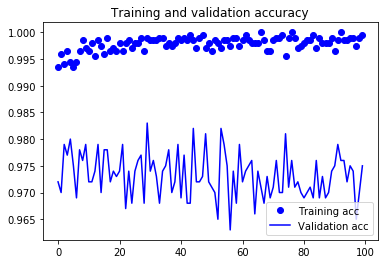

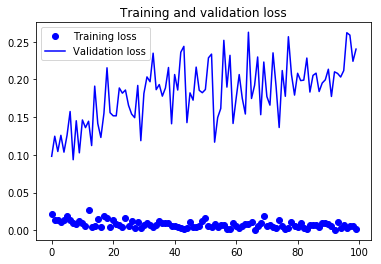

In [22]:
ent_acc = history.history['acc']
val_acc = history.history['val_acc']
ent_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()


Al igual que con el ejemplo anterior, suavizamos las curvas para extraer más información:

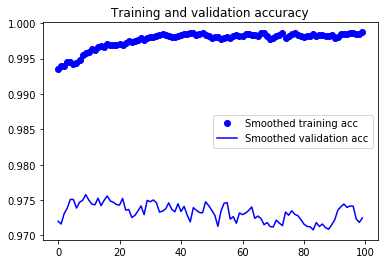

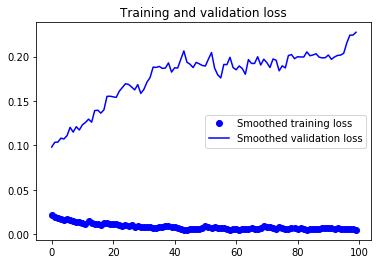

In [24]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(ent_acc), 'bo', label='Acc Entrenamiento Suavizada')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Acc Validación Suavizada')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(ent_loss), 'bo', label='Pérdida Entrenamiento Suavizada')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Pérdida Validación Suavizada')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()


Observamos que se alcanza una mejora de un 6%, alcanznado el 96%. 

Hay algo que debemos notar, y es que la curva de pérdida  no parece mejorar (incluso empeora),  a pesar de que la accuracy permanece estable o incluso mejora, ¿cómo es posible? La respuesta es simple, lo que se representa es una media de los valores de pérdida puntuales, pero lo que importa para la precisión es la distribución de los valores de pérdida, no su media, porque la precisión es el resultado de la binarización del valor predicho, por lo que el modelo puede mejorar incluso aunque esos valores se modifiquen ligeramente.

Por fin, podemos evaluar el modelo sobre los datos de test:

In [27]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.967999992371



Donde obtenemos una precisión del 96.5%, y solo con 2,000 muestras, no con las 20,000 que venían en la competición original de Kaggle de la que se han extraido nuestras muestras.


## Conclusiones

* Las redes convolucionales aportan los mejores modelos de ML para tareas de visión artificial. Incluso es posible entrenar una red desde cero sobre pocas muestras obteniendo resultados decentes.
* El sobreajuste es el principal problema cuando se trabaja con datasets pequeños. Entre las técnicas de regularización vistas, **data augmentation** puede ser una ayuda esencial cuando se trabaja con imágenes.
* Es fácil reutilizar una red convolucional previamente entrenada por medio de la **extracción de características**. Es rápido y funciona bien con datasets pequeños.
* Como complemento a la extracción de características, el **ajuste fino** puede adaptar las representaciones aprendidas previamente por un modelo dado para ajustarlo a un problema distinto. Los recursos necesarios son más elevados, pero si se dispone de los recursos computacionales, el rendimiento obtenido es considerablemente superior.